In [2]:
# Training 4 models: Random Forest, Logisitc Regression, XGBoost, LightGBM
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
# Load dataset
df = pd.read_csv("../data/pd_collisions_datasd.csv")

# fixing datetime
df['date_time'] = pd.to_datetime(df['date_time'])

df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month
df['is_weekend'] = df['day_of_week'].apply(lambda x: x >= 5)
df['rush_hour'] = df['hour'].apply(lambda x: 7 <= x <= 9 or 16 <= x <= 18)

# Target Engineering (severity)
df['severity'] = df['injured'] + 3 * df['killed']
df['severity_label'] = pd.cut(df['severity'], bins=[-1, 0, 2, 100], labels=['none', 'injury', 'fatal'])

# selecting features
features = ['hour', 'day_of_week', 'month', 'is_weekend', 'rush_hour', 
            'police_beat', 'violation_type', 'hit_run_lvl']
target = 'severity_label'

df_model = df[features + [target]].dropna()

# encode categorical features
cat_cols = ['police_beat', 'violation_type', 'hit_run_lvl']
for col in cat_cols:
    df_model[col] = LabelEncoder().fit_transform(df_model[col].astype(str))

df_model['is_weekend'] = df_model['is_weekend'].astype(int)
df_model['rush_hour'] = df_model['rush_hour'].astype(int)

print(df_model.head())

    hour  day_of_week  month  ...  violation_type  hit_run_lvl  severity_label
0     12            3      3  ...               2            1            none
3     11            0      7  ...               2            1            none
5      7            0      9  ...               2            1            none
7     11            0      1  ...               2            1            none
11     8            0      2  ...               2            1            none

[5 rows x 9 columns]


In [10]:
# Encode target
label_encoder = LabelEncoder()
df_model[target] = label_encoder.fit_transform(df_model[target])

# Seperate features and target
X = df_model.drop('severity_label', axis=1)
y = df_model['severity_label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Handle imbalance with SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [11]:
# Define models
models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", scale_pos_weight=1, random_state=42),
    "LigthGBM": LGBMClassifier(class_weight='balanced', random_state=42)
}

In [12]:
# Fit and Evaluate
results = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
    results[name] = report
    print(f"Classification Report for {name}: ")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    print("\n")

Classification Report for Random Forest: 
              precision    recall  f1-score   support

       fatal       0.04      0.13      0.06        61
      injury       0.17      0.26      0.21      1221
        none       0.88      0.79      0.83      7852

    accuracy                           0.71      9134
   macro avg       0.36      0.39      0.37      9134
weighted avg       0.78      0.71      0.74      9134





/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:39:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report for LogisticRegression: 
              precision    recall  f1-score   support

       fatal       0.17      0.44      0.25        61
      injury       0.15      0.34      0.21      1221
        none       0.88      0.70      0.78      7852

    accuracy                           0.65      9134
   macro avg       0.40      0.50      0.41      9134
weighted avg       0.78      0.65      0.70      9134



Classification Report for XGBoost: 
              precision    recall  f1-score   support

       fatal       0.02      0.13      0.04        61
      injury       0.17      0.30      0.22      1221
        none       0.88      0.74      0.80      7852

    accuracy                           0.68      9134
   macro avg       0.36      0.39      0.35      9134
weighted avg       0.78      0.68      0.72      9134



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006105 seconds.
You can set `force_row_wise=true` to remove the

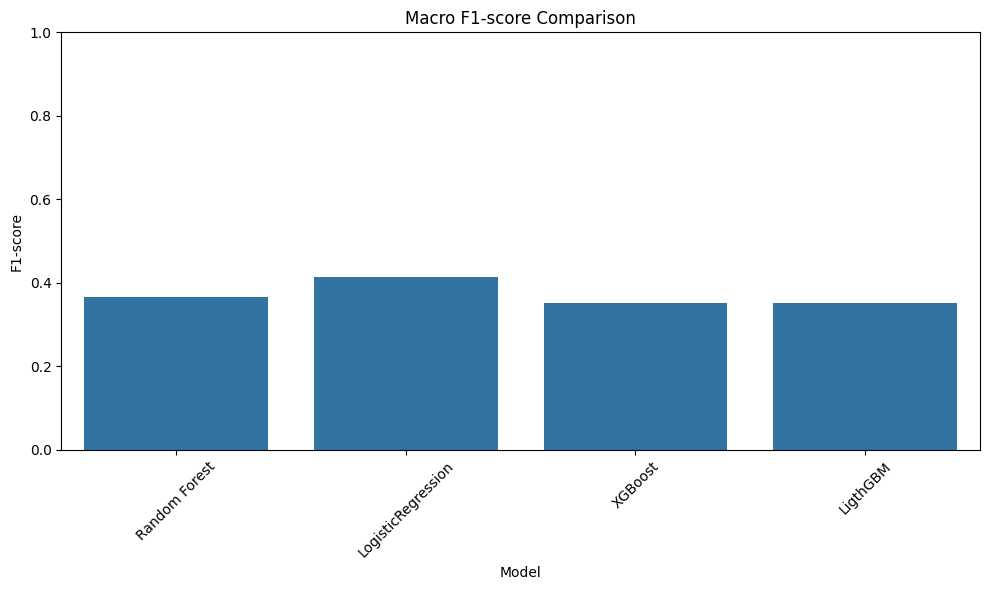

In [15]:
# Plot Macro F1-scores
macro_f1_scores = [results[m]['macro avg']['f1-score'] for m in models]
plt.figure(figsize=(10,6))
sns.barplot(x=list(models.keys()), y=macro_f1_scores)
plt.title("Macro F1-score Comparison")
plt.ylabel("F1-score")
plt.xlabel("Model")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()